# Feature Selection Lab - Loan Prediction Dataset

This lab will use a synthetic loan prediction dataset found [here](https://www.kaggle.com/datasets/nabihazahid/loan-prediction-dataset-2025/data).

## Imports

In [30]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif, mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
!pip install boruta
from boruta import BorutaPy

## Load Dataset

In [32]:
df = pd.read_csv('./data/loan_prediction.csv')
df.describe(include='all')

,age,gender,marital_status,education_level,annual_income,monthly_income,employment_status,debt_to_income_ratio,credit_score,loan_amount,...,loan_term,installment,grade_subgrade,num_of_open_accounts,total_credit_limit,current_balance,delinquency_history,public_records,num_of_delinquencies,loan_paid_back
count,20000.000000,20000,20000,20000,20000.000000,20000.000000,20000,20000.000000,20000.00000,20000.000000,...,20000.00000,20000.000000,20000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
unique,NaN,3,4,5,NaN,NaN,5,NaN,NaN,NaN,...,NaN,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Female,Single,Bachelor's,NaN,NaN,Employed,NaN,NaN,NaN,...,NaN,NaN,C3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,10034,9031,8045,NaN,NaN,13007,NaN,NaN,NaN,...,NaN,NaN,1514,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,48.027000,NaN,NaN,NaN,43549.637765,3629.136466,NaN,0.177019,679.25695,15129.300909,...,43.22280,455.625794,NaN,5.011800,48649.824769,24333.394631,1.990150,0.061800,2.489150,0.799900
std,15.829352,NaN,NaN,NaN,28668.579671,2389.048326,NaN,0.105059,69.63858,8605.405513,...,11.00838,274.622125,NaN,2.244529,32423.378128,22313.845395,1.474945,0.285105,1.631384,0.400085
min,21.000000,NaN,NaN,NaN,6000.000000,500.000000,NaN,0.010000,373.00000,500.000000,...,36.00000,9.430000,NaN,0.000000,6157.800000,496.350000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,NaN,NaN,NaN,24260.752500,2021.730000,NaN,0.096000,632.00000,8852.695000,...,36.00000,253.910000,NaN,3.000000,27180.492500,9592.572500,1.000000,0.000000,1.000000,1.000000
50%,48.000000,NaN,NaN,NaN,36585.260000,3048.770000,NaN,0.160000,680.00000,14946.170000,...,36.00000,435.595000,NaN,5.000000,40241.615000,18334.555000,2.000000,0.000000,2.000000,1.000000
75%,62.000000,NaN,NaN,NaN,54677.917500,4556.495000,NaN,0.241000,727.00000,20998.867500,...,60.00000,633.595000,NaN,6.000000,60361.257500,31743.327500,3.000000,0.000000,3.000000,1.000000


In [33]:
df.head()

,age,gender,marital_status,education_level,annual_income,monthly_income,employment_status,debt_to_income_ratio,credit_score,loan_amount,...,loan_term,installment,grade_subgrade,num_of_open_accounts,total_credit_limit,current_balance,delinquency_history,public_records,num_of_delinquencies,loan_paid_back
0,59,Male,Married,Master's,24240.19,2020.02,Employed,0.074,743,17173.72,...,36,581.88,B5,7,40833.47,24302.07,1,0,1,1
1,72,Female,Married,Bachelor's,20172.98,1681.08,Employed,0.219,531,22663.89,...,60,573.17,F1,5,27968.01,10803.01,1,0,3,1
2,49,Female,Single,High School,26181.80,2181.82,Employed,0.234,779,3631.36,...,60,76.32,B4,2,15502.25,4505.44,0,0,0,1
3,35,Female,Single,High School,11873.84,989.49,Employed,0.264,809,14939.23,...,36,468.07,A5,7,18157.79,5525.63,4,0,5,1
4,63,Other,Single,Other,25326.44,2110.54,Employed,0.260,663,16551.71,...,60,395.50,D5,1,17467.56,3593.91,2,0,2,1


## Preprocessing

This dataset includes several categorical variables, which we'll one-hot encode (except for grade_subgrade, which we will ordinally encode).

In [34]:
cats = df.select_dtypes(include=['object', 'category']).columns
for col in cats:
    print(f"{col}: {df[col].nunique()} categories")

gender: 3 categories
marital_status: 4 categories
education_level: 5 categories
employment_status: 5 categories
loan_purpose: 8 categories
grade_subgrade: 30 categories


In [35]:
oh_cols = list(set(cats) - set(['grade_subgrade']))
df = pd.get_dummies(df, columns=oh_cols, drop_first=True)

In [36]:
df['grade_subgrade'].unique()

array(['B5', 'F1', 'B4', 'A5', 'D5', 'B1', 'B3', 'A3', 'C4', 'C3', 'C2',
       'D4', 'D3', 'C1', 'E3', 'F4', 'C5', 'F3', 'F5', 'A2', 'D2', 'A4',
       'E5', 'D1', 'E1', 'E2', 'B2', 'E4', 'F2', 'A1'], dtype=object)

We're assuming that these are ordinal grades, so we'll apply ordinal encoding using the mapping below.

In [37]:
order = ['A1','A2','A3','A4','A5',
         'B1','B2','B3','B4','B5',
         'C1','C2','C3','C4','C5',
         'D1','D2','D3','D4','D5',
         'E1','E2','E3','E4','E5',
         'F1','F2','F3','F4','F5']

mapping = {grade: i+1 for i, grade in enumerate(order)}

df['grade_subgrade_encoded'] = df['grade_subgrade'].map(mapping)
print(df['grade_subgrade_encoded'])

0        10
1        26
2         9
3         5
4        20
         ..
19995    15
19996    10
19997     9
19998    17
19999    17
Name: grade_subgrade_encoded, Length: 20000, dtype: int64


In [38]:
df = df.drop(['grade_subgrade'], axis=1)
df.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('bool')], dtype=object)

## Baseline Model Training

We'll use a basic random forest model for this lab.

In [39]:
X = df.drop('loan_paid_back', axis=1)
Y = df['loan_paid_back']

In [40]:
def fit_model(X, Y):
    model = RandomForestClassifier(random_state=42)
    model.fit(X, Y)
    return model

In [41]:
def calculate_metrics(model, X_test, Y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    roc = roc_auc_score(Y_test, y_pred)
    prec = precision_score(Y_test, y_pred)
    rec = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    
    return accuracy, roc, prec, rec, f1

In [42]:
def train_and_get_metrics(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state = 123)
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = fit_model(X_train_scaled, Y_train)

    acc, roc, prec, rec, f1 = calculate_metrics(model, X_test_scaled, Y_test)

    return acc, roc, prec, rec, f1

In [43]:
def evaluate_model_on_features(X, Y):
    acc, roc, prec, rec, f1 = train_and_get_metrics(X, Y)
    display_df = pd.DataFrame([[acc, roc, prec, rec, f1, X.shape[1]]], columns=["Accuracy", "ROC", "Precision", "Recall", "F1 Score", 'Feature Count'])
    
    return display_df

In [44]:
# Calculate evaluation metrics
all_features_eval_df = evaluate_model_on_features(X, Y)
all_features_eval_df.index = ['All features']

# Initialize results dataframe
results = all_features_eval_df

# Check the metrics
results.head()

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.89775,0.758438,0.893209,0.990625,0.939398,36


## Feature Selection

### Correlation


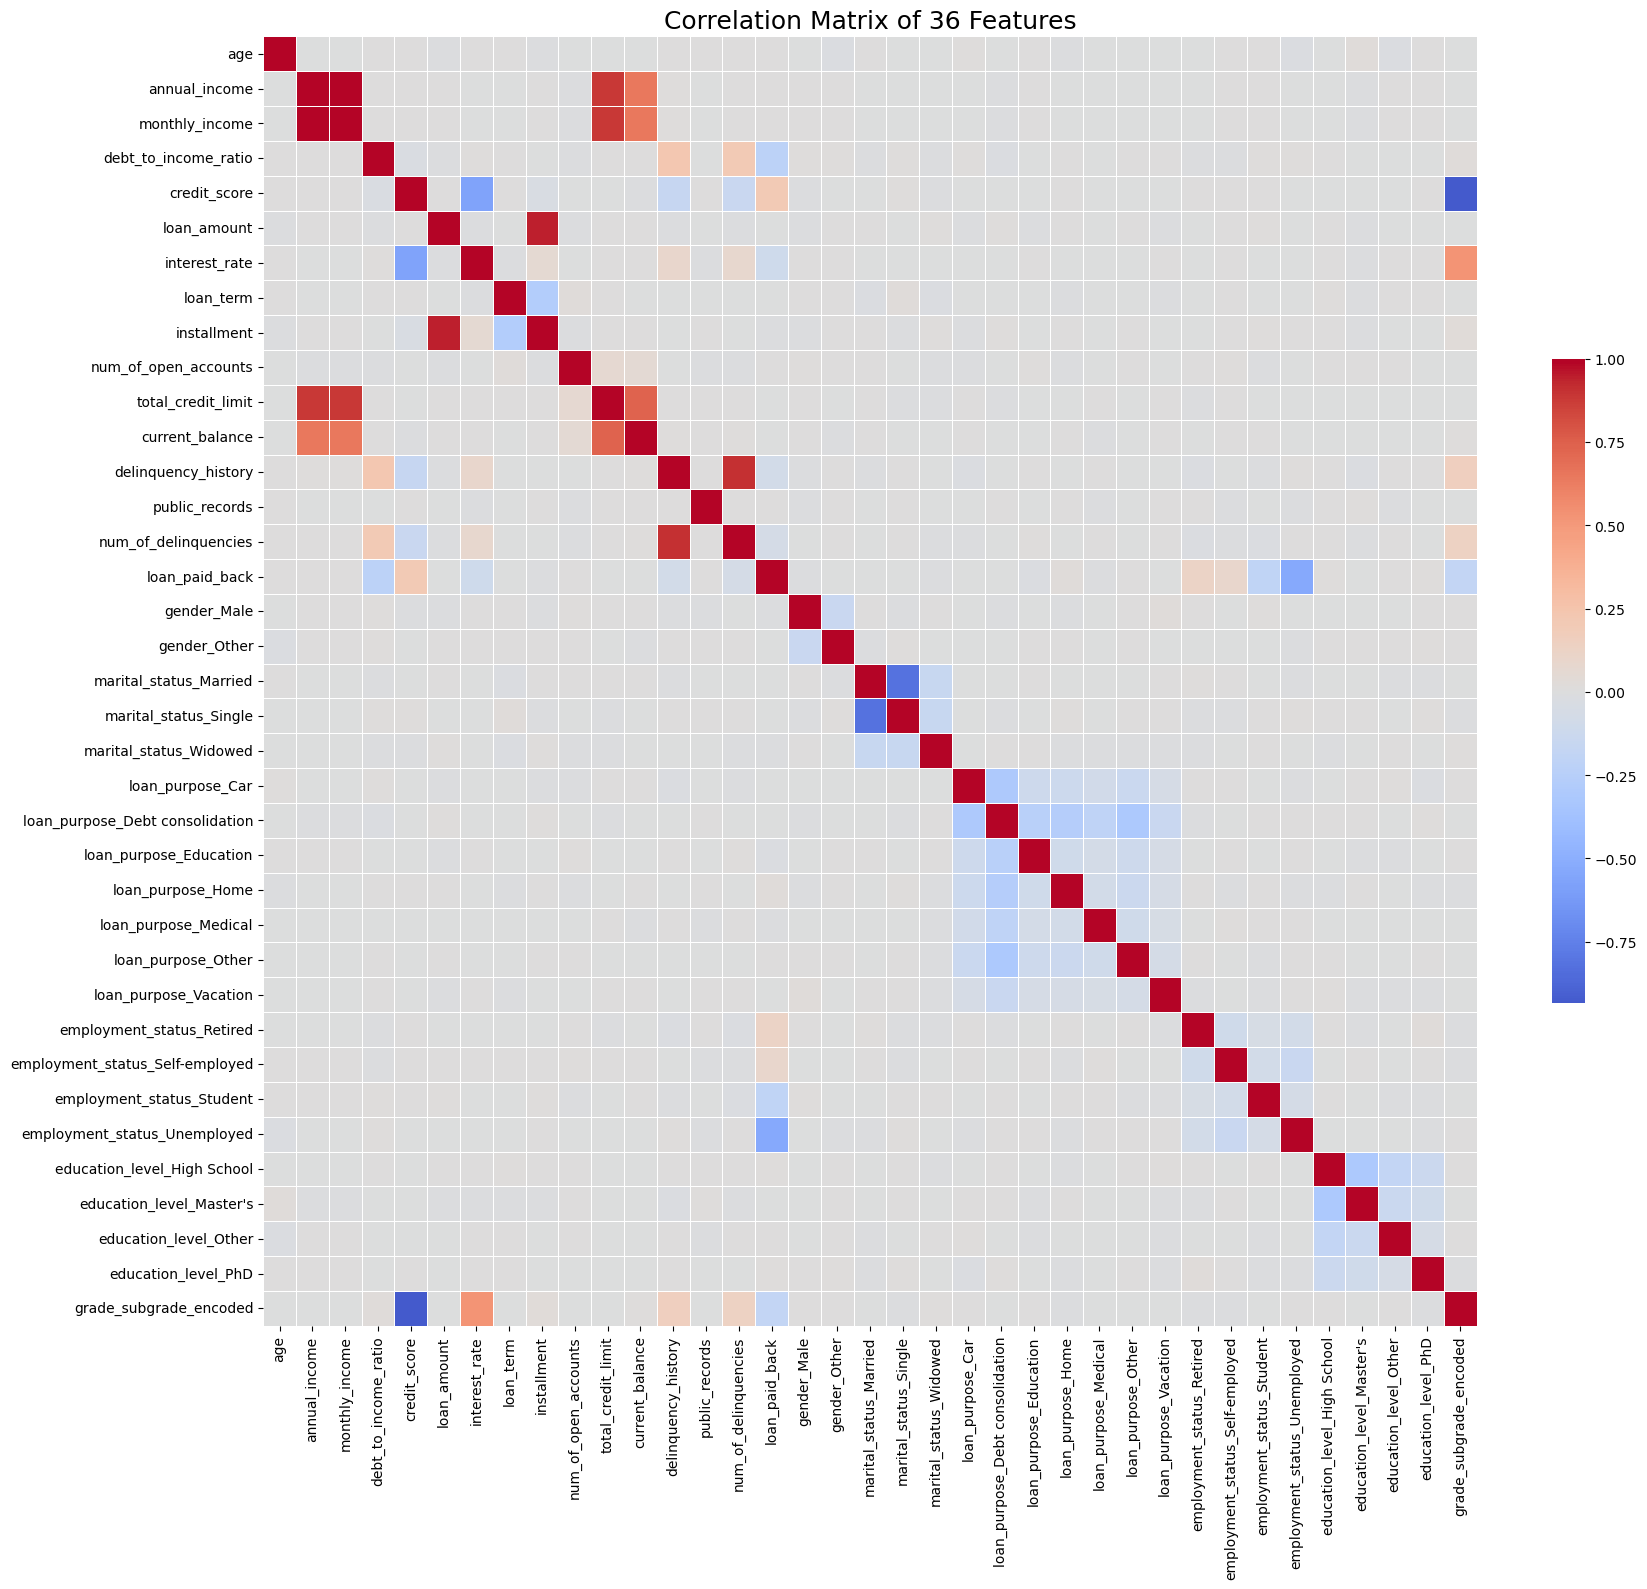

In [45]:
corr_matrix = df.corr()

# Large figure and tighter layout for legibility
plt.figure(figsize=(18, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0,
            linewidths=0.5, cbar_kws={'shrink': 0.5})
plt.title("Correlation Matrix of 36 Features", fontsize=18)
plt.tight_layout()
plt.show()

In [46]:
# Correlation with target
target_corr = corr_matrix['loan_paid_back'].sort_values(ascending=False)
print("Correlation with target:\n", target_corr)

Correlation with target:
 loan_paid_back                     1.000000
credit_score                       0.199841
employment_status_Retired          0.121825
employment_status_Self-employed    0.088762
loan_purpose_Home                  0.019953
education_level_PhD                0.014558
education_level_High School        0.013249
age                                0.007999
public_records                     0.003210
monthly_income                     0.003057
annual_income                      0.003057
num_of_open_accounts               0.002964
education_level_Other              0.002722
loan_purpose_Other                 0.002718
marital_status_Married             0.000929
marital_status_Single             -0.000728
loan_purpose_Debt consolidation   -0.001021
loan_purpose_Car                  -0.001449
loan_amount                       -0.002490
education_level_Master's          -0.002513
gender_Other                      -0.002548
loan_term                         -0.002615
total_

In [47]:
# Correlation with other features (exclude target)
feature_corr = corr_matrix.drop('loan_paid_back', axis=1).drop('loan_paid_back', axis=0)
print("\nFeature-to-feature correlation:\n", feature_corr)


Feature-to-feature correlation:
                                       age  annual_income  monthly_income  \
age                              1.000000      -0.002051       -0.002051   
annual_income                   -0.002051       1.000000        1.000000   
monthly_income                  -0.002051       1.000000        1.000000   
debt_to_income_ratio             0.007303       0.002760        0.002760   
credit_score                     0.004059       0.003837        0.003837   
loan_amount                     -0.008233       0.005094        0.005094   
interest_rate                    0.009768      -0.001186       -0.001186   
loan_term                        0.002331       0.001617        0.001617   
installment                     -0.008398       0.003843        0.003843   
num_of_open_accounts             0.001761      -0.005951       -0.005951   
total_credit_limit               0.001787       0.885358        0.885358   
current_balance                 -0.001587       0.6517

### Univariate Selection

In [48]:
def univariate_selection():
    
    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state = 123)
    
    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # User SelectKBest to select top 20 features based on f-test
    selector = SelectKBest(f_classif, k=20)
    
    # Fit to scaled data, then transform it
    X_new = selector.fit_transform(X_train_scaled, Y_train)
    
    # Print the results
    feature_idx = selector.get_support()
    for name, included in zip(df.drop("loan_paid_back", axis=1).columns, feature_idx):
        print("%s: %s" % (name, included))
    
    # Drop the target variable
    feature_names = df.drop("loan_paid_back", axis=1).columns[feature_idx]
    
    return feature_names

In [49]:
univariate_feature_names = univariate_selection()

# Calculate and check model metrics
univariate_eval_df = evaluate_model_on_features(df[univariate_feature_names], Y)
univariate_eval_df.index = ['F-test']

# Append to results and display
results = pd.concat([results, univariate_eval_df])
results.head(n=10)

age: True
annual_income: False
monthly_income: False
debt_to_income_ratio: True
credit_score: True
loan_amount: False
interest_rate: True
loan_term: False
installment: True
num_of_open_accounts: False
total_credit_limit: True
current_balance: False
delinquency_history: True
public_records: False
num_of_delinquencies: True
gender_Male: True
gender_Other: False
marital_status_Married: False
marital_status_Single: False
marital_status_Widowed: True
loan_purpose_Car: False
loan_purpose_Debt consolidation: False
loan_purpose_Education: True
loan_purpose_Home: True
loan_purpose_Medical: True
loan_purpose_Other: False
loan_purpose_Vacation: False
employment_status_Retired: True
employment_status_Self-employed: True
employment_status_Student: True
employment_status_Unemployed: True
education_level_High School: True
education_level_Master's: False
education_level_Other: False
education_level_PhD: True
grade_subgrade_encoded: True


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.89775,0.758438,0.893209,0.990625,0.939398,36
F-test,0.89750,0.762031,0.894960,0.987812,0.939097,20


### Recursive Feature Elimination

In [50]:
def run_rfe():
    
    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state = 123)
    
    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the model
    model = RandomForestClassifier(criterion='entropy', random_state=47)
    
    # Wrap RFE around the model
    rfe = RFE(model, n_features_to_select=20)
    
    # Fit RFE
    rfe = rfe.fit(X_train_scaled, Y_train)
    feature_names = df.drop("loan_paid_back", axis=1).columns[rfe.get_support()]
    
    return feature_names

rfe_feature_names = run_rfe()

In [51]:
# Calculate and check model metrics
rfe_eval_df = evaluate_model_on_features(df[rfe_feature_names], Y)
rfe_eval_df.index = ['RFE']

# Append to results and display
results = pd.concat([results, rfe_eval_df])
results.head(n=10)

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.89775,0.758438,0.893209,0.990625,0.939398,36
F-test,0.89750,0.762031,0.894960,0.987812,0.939097,20
RFE,0.90000,0.763594,0.895257,0.990938,0.940670,20


### Feature Importances

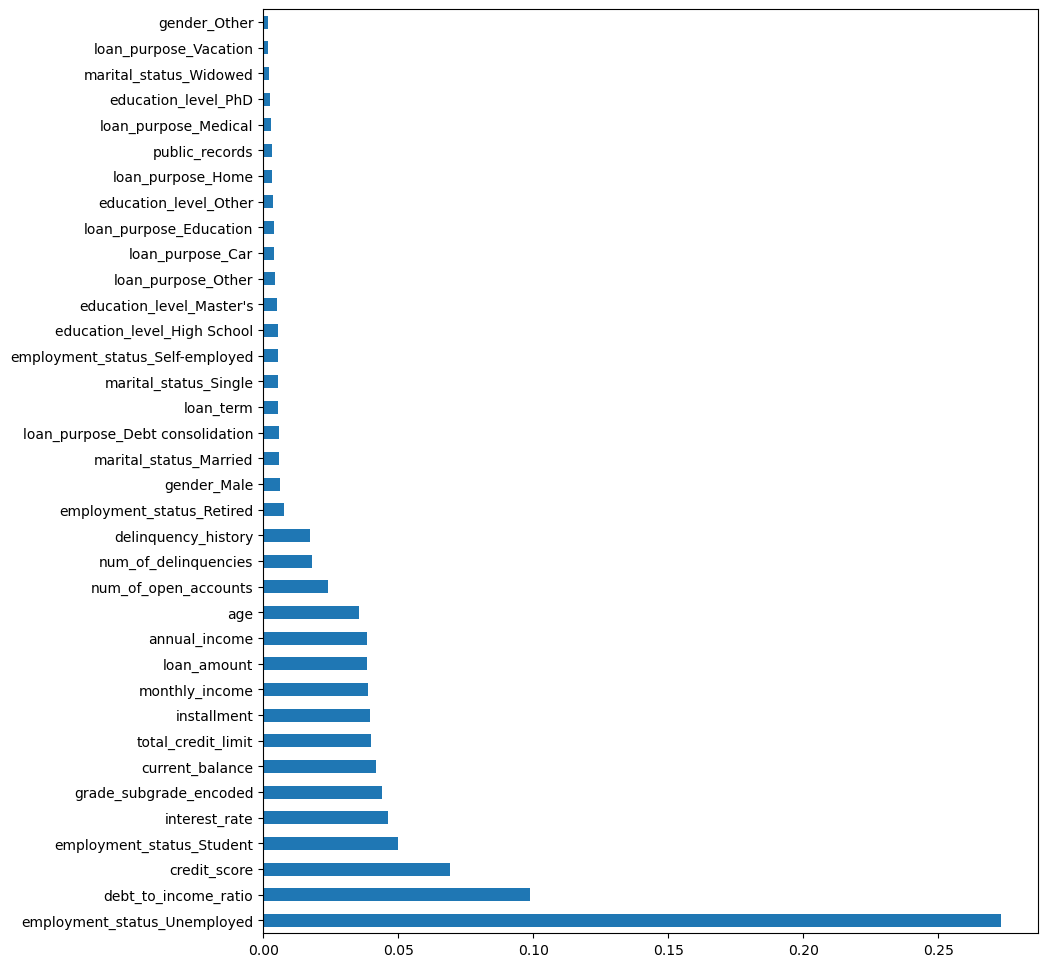

In [52]:
def feature_importances_from_tree_based_model_():
    
    # Split train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state = 123)
    
    # Define the model to use
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestClassifier()
    model = model.fit(X_train_scaled,Y_train)
    
    # Plot feature importance
    plt.figure(figsize=(10, 12))
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.sort_values(ascending=False).plot(kind='barh')
    plt.show()
    
    return model


def select_features_from_model(model):
    
    model = SelectFromModel(model, prefit=True, threshold=0.013)
    feature_idx = model.get_support()
    feature_names = df.drop("loan_paid_back", axis=1).columns[feature_idx]
        
    return feature_names

model = feature_importances_from_tree_based_model_()
feature_imp_feature_names = select_features_from_model(model)

In [53]:
# Calculate and check model metrics
feat_imp_eval_df = evaluate_model_on_features(df[feature_imp_feature_names], Y)
feat_imp_eval_df.index = ['Feature Importance']

# Append to results and display
results = pd.concat([results, feat_imp_eval_df])
results.head(n=10)

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.89775,0.758438,0.893209,0.990625,0.939398,36
F-test,0.89750,0.762031,0.894960,0.987812,0.939097,20
RFE,0.90000,0.763594,0.895257,0.990938,0.940670,20
Feature Importance,0.89700,0.760313,0.894231,0.988125,0.938836,16


### Mutual Information

Mutual Information (MI) measures the dependency between each feature and the target variable. Unlike linear correlation, MI can capture non-linear relationships, making it a powerful filter method for feature selection.

In this analysis, we compute the MI scores for all features with respect to the binary target loan_paid_back and select the top features with the highest scores for downstream modeling.

In [54]:
def mutual_info_selection():
    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=123)
    
    # Normalize features
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Compute mutual information scores
    mi_scores = mutual_info_classif(X_train_scaled, Y_train, discrete_features='auto', random_state=42)
    
    # Create DataFrame for easier display
    mi_df = pd.DataFrame({
        'Feature': df.drop('loan_paid_back', axis=1).columns,
        'MI_Score': mi_scores
    }).sort_values(by='MI_Score', ascending=False)
    
    # Select top 20 features
    top_features = mi_df['Feature'].head(20).tolist()
    
    # Print results
    for feature in top_features:
        print(feature)
    
    return top_features

# Usage
mutual_info_feature_names = mutual_info_selection()
mutual_info_eval_df = evaluate_model_on_features(df[mutual_info_feature_names], Y)
mutual_info_eval_df.index = ['Mutual Info']

# Update results
results = pd.concat([results, mutual_info_eval_df])
results.head(n=10)

employment_status_Unemployed
debt_to_income_ratio
credit_score
grade_subgrade_encoded
employment_status_Student
employment_status_Retired
delinquency_history
public_records
employment_status_Self-employed
loan_purpose_Education
num_of_delinquencies
loan_purpose_Debt consolidation
loan_purpose_Vacation
interest_rate
gender_Other
gender_Male
loan_term
loan_purpose_Car
loan_purpose_Medical
marital_status_Widowed


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.89775,0.758438,0.893209,0.990625,0.939398,36
F-test,0.89750,0.762031,0.894960,0.987812,0.939097,20
RFE,0.90000,0.763594,0.895257,0.990938,0.940670,20
Feature Importance,0.89700,0.760313,0.894231,0.988125,0.938836,16
Mutual Info,0.89875,0.765156,0.896229,0.987812,0.939795,20


## Boruta

Our last feature selection method will be Boruta, a wrapper method built on top of Random Forest. Boruta iteratively compares the importance of each real feature to shadow features (randomly shuffled versions), retaining only those that are significantly more informative than random. This makes Boruta a robust method for identifying truly relevant features while accounting for feature interactions and non-linear relationships.

In [55]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

def boruta_selection():
    # Random Forest for Boruta
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    
    # Boruta selector
    boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42, verbose=0)
    boruta_selector.fit(X.values, Y.values)
    
    # Selected features
    selected_features = df.drop('loan_paid_back', axis=1).columns[boruta_selector.support_].tolist()
    
    # Print results
    for feature in selected_features:
        print(feature)
    
    return selected_features

# Usage
boruta_feature_names = boruta_selection()
boruta_eval_df = evaluate_model_on_features(df[boruta_feature_names], Y)
boruta_eval_df.index = ['Boruta']

# Update results
results = pd.concat([results, boruta_eval_df])

debt_to_income_ratio
credit_score
interest_rate
employment_status_Student
employment_status_Unemployed
grade_subgrade_encoded


In [56]:
def boruta_selection():
    # Random Forest for Boruta
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    
    # Boruta selector
    boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42, verbose=0)
    boruta_selector.fit(X.values, Y.values)
    
    # Selected features
    selected_features = df.drop('loan_paid_back', axis=1).columns[boruta_selector.support_].tolist()
    
    # Print results
    for feature in selected_features:
        print(feature)
    
    return selected_features

# Usage
boruta_feature_names = boruta_selection()
boruta_eval_df = evaluate_model_on_features(df[boruta_feature_names], Y)
boruta_eval_df.index = ['Boruta']

# Update results
results = pd.concat([results, boruta_eval_df])
results.head(n=10)

debt_to_income_ratio
credit_score
interest_rate
employment_status_Student
employment_status_Unemployed
grade_subgrade_encoded


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.89775,0.758438,0.893209,0.990625,0.939398,36
F-test,0.89750,0.762031,0.894960,0.987812,0.939097,20
RFE,0.90000,0.763594,0.895257,0.990938,0.940670,20
Feature Importance,0.89700,0.760313,0.894231,0.988125,0.938836,16
Mutual Info,0.89875,0.765156,0.896229,0.987812,0.939795,20
Boruta,0.89400,0.766406,0.897708,0.979062,0.936622,6
Boruta,0.89400,0.766406,0.897708,0.979062,0.936622,6


Since we have a relatively high-dimensional dataset (especially after one-hot encoding categorical variables), these feature selection methods are highly effective in reducing dimensionality while retaining solid accuracy. Our best-performing method in terms of overall performance was RFE, which had higher accuracy, ROC, precision, recall, and F1 with 20 features than the random forest with all features. Boruta was the most efficient method, using only 6 features but achieving comparable metrics across the board. These are both good options depending on preferred efficiency/accuracy tradeoffs.